# 1. Polynomial Regression

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# Load and clean data
path = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Auto.csv'
df = pd.read_csv(path)
# ensure column names; common Auto dataset uses 'mpg' and 'horsepower'
df.columns = [c.strip() for c in df.columns]
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['mpg'] = pd.to_numeric(df['mpg'], errors='coerce')
df = df.dropna(subset=['mpg', 'horsepower']).copy()

# create polynomial terms up to degree 5
hp = df['horsepower']
for d in range(1, 6):
    df[f'hp{d}'] = hp ** d

# fit OLS models degree 1..5 (mpg ~ horsepower + horsepower^2 + ...)
models = []
for deg in range(1, 6):
    cols = [f'hp{i}' for i in range(1, deg + 1)]
    X = sm.add_constant(df[cols])
    model = sm.OLS(df['mpg'], X).fit()
    models.append(model)

# ANOVA comparing nested models 1..5
anova_all = anova_lm(*models)
print("ANOVA table comparing models degree 1..5:")
print(anova_all)

# Pairwise sequential tests and determine justified degree (alpha=0.05)
alpha = 0.05
justified_degree = 1
for i in range(0, 4):  # compare model i (degree i+1) vs model i+1 (degree i+2)
    anova_pair = anova_lm(models[i], models[i+1])
    F = anova_pair['F'].iloc[1]
    p = anova_pair['Pr(>F)'].iloc[1]
    deg_lower = i + 1
    deg_higher = i + 2
    print(f"\nComparison degree {deg_lower} vs {deg_higher}: F = {F:.4g}, p = {p:.4g}")
    if p < alpha:
        justified_degree = deg_higher
    else:
        # if adding the higher-degree term is not significant, stop considering larger degrees
        break

print(f"\nPolynomial degree statistically justified by sequential ANOVA (alpha={alpha}): {justified_degree}")

# Report F-statistic and p-value for cubic (degree 3) vs quartic (degree 4)
anova_3_vs_4 = anova_lm(models[2], models[3])  # models[2] is degree3, models[3] is degree4
F_3_4 = anova_3_vs_4['F'].iloc[1]
p_3_4 = anova_3_vs_4['Pr(>F)'].iloc[1]
print(f"\nCubic (degree 3) vs Quartic (degree 4): F = {F_3_4:.4g}, p = {p_3_4:.4g}")

ANOVA table comparing models degree 1..5:
   df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     390.0  9385.915872      0.0          NaN         NaN           NaN
1     389.0  7442.029412      1.0  1943.886460  103.876722  8.878263e-22
2     388.0  7426.436007      1.0    15.593405    0.833275  3.618941e-01
3     387.0  7399.522632      1.0    26.913375    1.438187  2.311666e-01
4     386.0  7223.371686      1.0   176.150946    9.413092  2.306429e-03

Comparison degree 1 vs 2: F = 101.6, p = 2.196e-21

Comparison degree 2 vs 3: F = 0.8147, p = 0.3673

Polynomial degree statistically justified by sequential ANOVA (alpha=0.05): 2

Cubic (degree 3) vs Quartic (degree 4): F = 1.408, p = 0.2362


# 2. Regression Splines with B-Splines

In [2]:
from scipy.interpolate import BSpline

# load Boston dataset
path_boston = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Boston.csv'
df_b = pd.read_csv(path_boston)
df_b.columns = [c.strip() for c in df_b.columns]
df_b['lstat'] = pd.to_numeric(df_b['lstat'], errors='coerce')
df_b['medv'] = pd.to_numeric(df_b['medv'], errors='coerce')
df_b = df_b.dropna(subset=['lstat', 'medv']).copy()

# predictor and response
x = df_b['lstat'].values
y = df_b['medv'].values

# B-spline parameters
internal_knots = [10, 20, 30]
k = 3  # cubic
xmin, xmax = x.min(), x.max()

# construct knot vector with boundary knots repeated k+1 times
t = np.r_[ [xmin] * (k + 1), internal_knots, [xmax] * (k + 1) ]

# number of B-spline basis functions (ncoef)
ncoef = len(internal_knots) + k + 1  # = 3 + 3 + 1 = 7

# build B-spline basis matrix: each column is one basis function evaluated at x
B = np.column_stack([BSpline(t, np.eye(ncoef)[i], k)(x) for i in range(ncoef)])

# include intercept in the regression (adds a constant column)
X_bs = sm.add_constant(B)

# fit OLS
model_bs = sm.OLS(y, X_bs).fit()

# report results
print("R-squared:", model_bs.rsquared)
print("Number of B-spline basis functions (excluding intercept):", B.shape[1])
print("Design matrix shape (including intercept):", X_bs.shape)

R-squared: 0.6834878749017886
Number of B-spline basis functions (excluding intercept): 7
Design matrix shape (including intercept): (506, 8)


# 3. Natural Splines


In [10]:
# load Hitters dataset
df_hitters = pd.read_csv('/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Hitters.csv', index_col=0)
df_hitters.columns = [c.strip() for c in df_hitters.columns]

# basic checks
print("Shape:", df_hitters.shape)


Shape: (322, 19)


R-squared: 0.2638024661127154


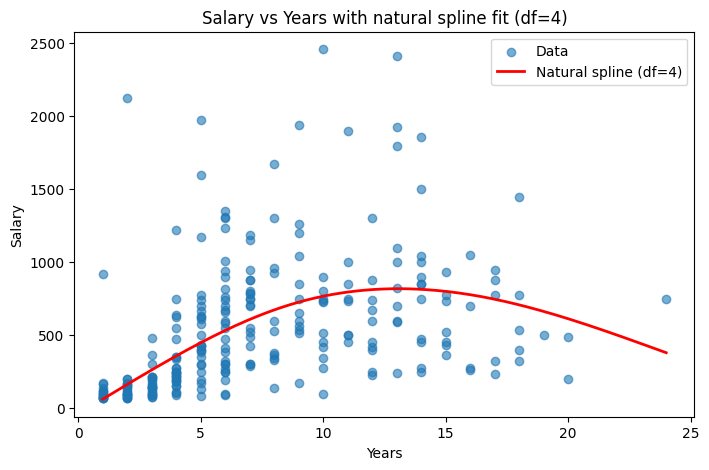

In [13]:
# use patsy to build natural spline basis (ISLP.ns returns a NaturalSpline object that doesn't support len())
from patsy import dmatrix
import matplotlib.pyplot as plt

# prepare data (drop missing Salary)
df_ns = df_hitters[['Years', 'Salary']].dropna().copy()

# build natural spline basis and fit OLS using patsy dmatrix (returns a DataFrame)
X_ns = dmatrix("cr(Years, df=4) - 1", {"Years": df_ns['Years']}, return_type='dataframe')
X_ns = X_ns.astype(float)                       # ensure homogeneous numeric dtype
X_ns = sm.add_constant(X_ns)                    # add intercept

# make sure endog and exog are numpy arrays of compatible shape
y_ns = df_ns['Salary'].values
model_ns = sm.OLS(y_ns, X_ns.values).fit()

# report R-squared
print("R-squared:", model_ns.rsquared)

# create smooth curve for plotting
years_grid = np.linspace(df_ns['Years'].min(), df_ns['Years'].max(), 200)
X_grid = dmatrix("cr(Years, df=4) - 1", {"Years": years_grid}, return_type='dataframe')
X_grid = X_grid.astype(float)
X_grid = sm.add_constant(X_grid)

y_pred = model_ns.predict(X_grid.values)

# plot scatter + fitted natural spline (sorted for a smooth line)
order = np.argsort(years_grid)
plt.figure(figsize=(8, 5))
plt.scatter(df_ns['Years'], df_ns['Salary'], alpha=0.6, label='Data')
plt.plot(years_grid[order], y_pred[order], color='red', linewidth=2, label='Natural spline (df=4)')
plt.xlabel('Years')
plt.ylabel('Salary')
plt.title('Salary vs Years with natural spline fit (df=4)')
plt.legend()
plt.show()

# 4. Generalized Additive Model (GAM)


In [14]:
# load College dataset
path_college = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/College.csv'
df_college = pd.read_csv(path_college, index_col=0)
df_college.columns = [c.strip() for c in df_college.columns]

# quick checks
print("Shape:", df_college.shape)
print("\nColumns:", df_college.columns.tolist())


Shape: (777, 18)

Columns: ['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate']


Training R-squared: 0.5142


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/scipy/linalg/_basic.py:1449: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/scipy/linalg/_basic.py:1449: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/scipy/linalg/_basic.py:1449: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


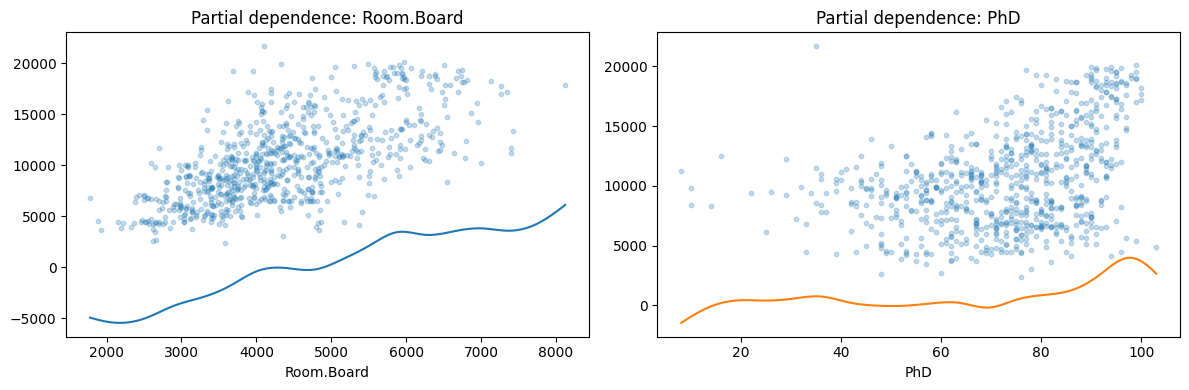

In [ ]:
# stop warning messages from pygam
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pygam import LinearGAM, s

# try to import optional ISLP helper plot_gam; fall back to manual plotting if unavailable
try:
    from ISLP.pygam import plot_gam
    has_islp_plot = True
except Exception:
    has_islp_plot = False

# fit a GAM predicting Outstate from Room.Board and PhD using pygam (default lambda)

# prepare data (use existing df_college)
df_gam = df_college[['Outstate', 'Room.Board', 'PhD']].dropna().copy()
X = df_gam[['Room.Board', 'PhD']].values
y = df_gam['Outstate'].values

# fit GAM with smoothing splines for both predictors (default lambda)
gam = LinearGAM(s(0) + s(1)).fit(X, y)

# report training R-squared
r2 = gam.score(X, y)
print(f"Training R-squared: {r2:.4f}")

# partial dependence plots for each term
if has_islp_plot:
    plt.figure(figsize=(8, 4))
    plot_gam(gam, term=0, xlabel='Room.Board', title='Partial dependence: Room.Board')
    plt.figure(figsize=(8, 4))
    plot_gam(gam, term=1, xlabel='PhD', title='Partial dependence: PhD')
    plt.show()
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # term 0 (Room.Board)
    XX0 = gam.generate_X_grid(term=0)
    pd0 = gam.partial_dependence(term=0, X=XX0)
    axes[0].plot(XX0[:, 0], pd0, color='C0')
    axes[0].scatter(X[:, 0], y, alpha=0.25, s=10)
    axes[0].set_xlabel('Room.Board'); axes[0].set_title('Partial dependence: Room.Board')
    # term 1 (PhD)
    XX1 = gam.generate_X_grid(term=1)
    pd1 = gam.partial_dependence(term=1, X=XX1)
    axes[1].plot(XX1[:, 1], pd1, color='C1')
    axes[1].scatter(X[:, 1], y, alpha=0.25, s=10)
    axes[1].set_xlabel('PhD'); axes[1].set_title('Partial dependence: PhD')
    plt.tight_layout()
    plt.show()

# 5. Step Functions

In [18]:
path_carseats = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Carseats.csv'
df_carseats = pd.read_csv(path_carseats)
df_carseats.columns = [c.strip() for c in df_carseats.columns]

print("Shape:", df_carseats.shape)
print("\nMissing values per column:")
print(df_carseats.isnull().sum())
print("\nColumn dtypes:")
print(df_carseats.dtypes)

# show first few rows
df_carseats.head()

Shape: (400, 11)

Missing values per column:
Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

Column dtypes:
Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [19]:
# Step function model: Sales ~ Price (4 bins)
# Uses existing df_carseats from the notebook

# prepare data
df_step = df_carseats[['Sales', 'Price']].dropna().copy()
df_step['Price_bin'] = pd.cut(df_step['Price'], bins=4)

# show bin counts
print("Price bin counts:")
print(df_step['Price_bin'].value_counts().sort_index())

# create indicator variables (drop one to avoid collinearity)
dummies = pd.get_dummies(df_step['Price_bin'], prefix='Price_bin', drop_first=True).astype(float)

# fit OLS with intercept
X = sm.add_constant(dummies)
y = df_step['Sales'].values
model_step = sm.OLS(y, X).fit()

# report coefficients for bin indicators and R-squared
print("\nCoefficient estimates (including intercept):")
print(model_step.params)
print(f"\nR-squared: {model_step.rsquared:.4f}")

# determine which price bin has strongest negative effect
coef_bins = model_step.params[dummies.columns]
most_negative_dummy = coef_bins.idxmin()
most_negative_value = coef_bins.min()
print(f"\nPrice bin with strongest negative effect on Sales: {most_negative_dummy} (coef = {most_negative_value:.4f})")

Price bin counts:
Price_bin
(23.833, 65.75]      7
(65.75, 107.5]     139
(107.5, 149.25]    222
(149.25, 191.0]     32
Name: count, dtype: int64

Coefficient estimates (including intercept):
const                        10.960000
Price_bin_(65.75, 107.5]     -2.301295
Price_bin_(107.5, 149.25]    -4.006532
Price_bin_(149.25, 191.0]    -5.504375
dtype: float64

R-squared: 0.1478

Price bin with strongest negative effect on Sales: Price_bin_(149.25, 191.0] (coef = -5.5044)
